## PERKENALAN DATASET
Dataset hasil scrappping yang saya ambil adalah data dari komentar 3 video youtube windah basudara yang komentar nya berjumlah kurang lebih 26.000 data atau sampel, data ini memiliki 4 aktegori, yaitu link video, isi koemntar, penulis koemntar, dan juga waktu koemntar dipublish.

## IMPORT LIBRARY

In [1]:
# Untuk manipulasi data
import pandas as pd
import numpy as np
# Untuk visualisasi (opsional tapi berguna)
import matplotlib.pyplot as plt
import seaborn as sns
# Untuk preprocessing teks
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Untuk modeling dengan deep learning (menggunakan TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D, Conv1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Untuk evaluasi
from sklearn.metrics import classification_report, confusion_matrix
# (Opsional) untuk menggunakan BERT
# from transformers import BertTokenizer, TFBertForSequenceClassification
# Pastikan library NLTK sudah di-download


## READ DATASET

In [2]:
# Baca dataset dari file CSV
df = pd.read_csv('komentar_youtube_windah.csv')
# Tampilkan 5 baris pertama untuk memastikan data terbaca
print(df.head())

                                     video_url                   author  \
0  https://www.youtube.com/watch?v=hzUG58aJ124              @GGytGaming   
1  https://www.youtube.com/watch?v=hzUG58aJ124  @yoelvarel1thunlalu.820   
2  https://www.youtube.com/watch?v=hzUG58aJ124           @almerstsy8111   
3  https://www.youtube.com/watch?v=hzUG58aJ124              @yndtks5996   
4  https://www.youtube.com/watch?v=hzUG58aJ124              @Nathan-b1k   

                                                text               time  
0  Most wanted ini masih yang terbaik tanpa adany...  4 tahun yang lalu  
1                   Emang ada yang nonton dari 2025?  3 bulan yang lalu  
2                     masih ada yg nonton dari 2024?  4 bulan yang lalu  
3                           Sorry bang telat 1 tahun  3 tahun yang lalu  
4  Gua percaya yg nonton ini sebagian besar penge...  5 tahun yang lalu  


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26000 entries, 0 to 25999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   video_url  26000 non-null  object
 1   author     26000 non-null  object
 2   text       26000 non-null  object
 3   time       26000 non-null  object
dtypes: object(4)
memory usage: 812.6+ KB


In [4]:
df.describe()

,video_url,author,text,time
count,26000,26000,26000,26000
unique,2,19163,19352,41
top,https://www.youtube.com/watch?v=hzUG58aJ124,@nunuksetyaningwati8894,Sorry bang telat 2 tahun,3 tahun yang lalu
freq,16731,72,122,10660


## CLEANING DATASET

In [5]:
# Hapus kolom video_url
df.drop(columns='video_url', inplace=True)
print("Kolom 'video_url' berhasil dihapus.")


Kolom 'video_url' berhasil dihapus.


In [6]:
# Cek missing values per kolom
missing_data = df.isnull().sum()
print("Jumlah missing values tiap kolom:")
print(missing_data)

Jumlah missing values tiap kolom:
author    0
text      0
time      0
dtype: int64


In [7]:
# Cek jumlah baris yang sepenuhnya duplikat
duplicate_rows = df[df.duplicated(keep=False)]
print(f"Jumlah baris duplikat (seluruh kolom): {duplicate_rows.shape[0]}")
display(duplicate_rows)

Jumlah baris duplikat (seluruh kolom): 8826


,author,text,time
0,@GGytGaming,Most wanted ini masih yang terbaik tanpa adany...,4 tahun yang lalu
1,@yoelvarel1thunlalu.820,Emang ada yang nonton dari 2025?,3 bulan yang lalu
2,@almerstsy8111,masih ada yg nonton dari 2024?,4 bulan yang lalu
3,@yndtks5996,Sorry bang telat 1 tahun,3 tahun yang lalu
4,@Nathan-b1k,Gua percaya yg nonton ini sebagian besar penge...,5 tahun yang lalu
...,...,...,...
25947,@ilhamkurniawan8958,hahaha untung gw nontonnya pas udah buka mang\...,3 tahun yang lalu
25960,@evnz1818,0:05 Top 10 Best Cosplay in the World,3 tahun yang lalu
25982,@muhammadfaizpmm2411,3:50 Thanks you Garena dong bang 😂🗿,3 tahun yang lalu
25988,@rakapratama,yg ini dibayar sm supercell bro wwkwkwk,3 tahun yang lalu


In [8]:
# Hapus duplikasi dari seluruh baris
df.drop_duplicates(inplace=True)

In [9]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
25994    False
25995    False
25996    False
25998    False
25999    False
Length: 21430, dtype: bool

In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
import random

# Download data NLTK
nltk.download('punkt')
nltk.download('stopwords')

#  Lowercase + Hapus karakter khusus
def clean_text(text):
    text = re.sub(r'http\S+|www.\S+', '', text)  # hapus link
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)   # hapus mention
    text = re.sub(r'#\S+', '', text)            # hapus hashtag
    text = re.sub(r'[^a-zA-Z\s]', '', text)     # hapus karakter non-huruf
    text = text.lower().strip()
    return text

df['cleaned'] = df['text'].apply(clean_text)

#  Tokenisasi
tokenizer = TreebankWordTokenizer()
df['tokens'] = df['cleaned'].apply(tokenizer.tokenize)


#  Hapus stopwords Bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

#  Gabungkan kembali token jadi string (jika ingin input ke model)
df['clean_text'] = df['tokens'].apply(lambda x: ' '.join(x))



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\padla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\padla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

df['stemmed'] = df['tokens'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])


In [12]:
df['processed'] = df['stemmed'].apply(lambda tokens: ' '.join(tokens))

In [19]:
from transformers import AutoTokenizer

# Load tokenizer dari model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# Fungsi untuk memotong teks berdasarkan token
def truncate_text(text, max_length=512):
    encoded = tokenizer.encode_plus(
        text,
        max_length=max_length,
        truncation=True,  # Aktifkan pemotongan otomatis
        padding="max_length",  # Tambahkan padding jika diperlukan
        return_tensors="pt"  # Kembalikan sebagai tensor
    )
    return tokenizer.decode(encoded["input_ids"][0], skip_special_tokens=True)

# Terapkan ke kolom 'processed'
df['processed'] = df['processed'].apply(lambda x: truncate_text(x, max_length=512))

In [20]:
from transformers import pipeline

# Gunakan pipeline sentimen dari Hugging Face
sentiment_pipeline = pipeline("sentiment-analysis")

# Fungsi untuk prediksi sentimen
def predict_sentiment(processed):
    result = sentiment_pipeline(processed)[0]
    if result['label'] == 'NEGATIVE':
        return 0  # Negatif
    elif result['label'] == 'POSITIVE':
        return 2  # Positif
    else:
        return 1  # Netral

# Terapkan fungsi ke dataset
df['label'] = df['processed'].apply(predict_sentiment)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21430 entries, 0 to 25999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   author      21430 non-null  object
 1   text        21430 non-null  object
 2   time        21430 non-null  object
 3   cleaned     21430 non-null  object
 4   tokens      21430 non-null  object
 5   clean_text  21430 non-null  object
 6   stemmed     21430 non-null  object
 7   processed   21430 non-null  object
 8   label       21430 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 1.6+ MB


## MEMBANGUN MODEL & EVALUASI

In [23]:
# Split data menjadi train dan test
X = df['processed']
y = df['label']

# Tokenisasi dan padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=100, padding='post', truncating='post')

# Encode label
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Bangun model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 kelas: negatif, netral, positif
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

c:\Users\padla\OneDrive\Documents\Tugas\Dicoding\Analisis Sentimen\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.7647 - loss: 0.5138 - val_accuracy: 0.8430 - val_loss: 0.3364
Epoch 2/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.9081 - loss: 0.2328 - val_accuracy: 0.8703 - val_loss: 0.3161
Epoch 3/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.9410 - loss: 0.1535 - val_accuracy: 0.8684 - val_loss: 0.3120
Epoch 4/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.9594 - loss: 0.1114 - val_accuracy: 0.8665 - val_loss: 0.3366
Epoch 5/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.9669 - loss: 0.0905 - val_accuracy: 0.8724 - val_loss: 0.4107
Epoch 6/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.9748 - loss: 0.0676 - val_accuracy: 0.8705 - val_loss: 0.4113
Epoch 7/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.9808 - loss: 0.0558 - val_accuracy: 0.8712 - val_loss: 0.4382
Epoch 8/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.9828 - loss: 0.0480 - 

## VISUALISASI DATA

C:\Users\padla\AppData\Local\Temp\ipykernel_21096\1435167787.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette='viridis')


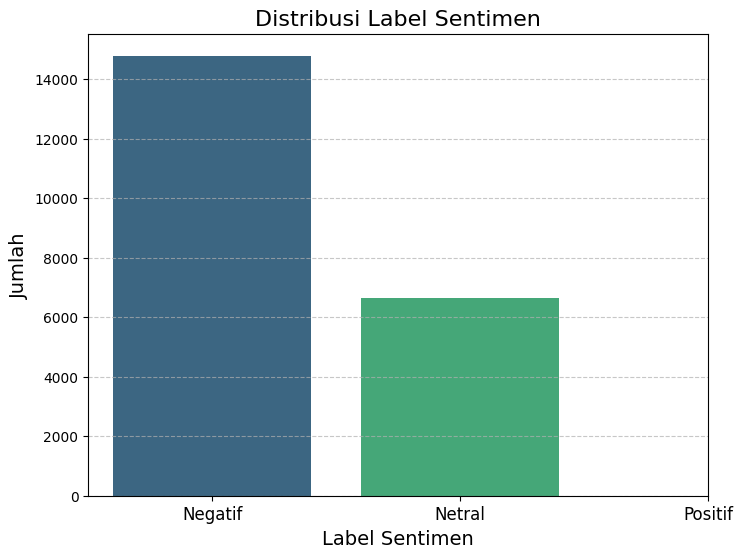

In [33]:
# Visualisasi distribusi label sentimen
plt.figure(figsize=(8, 6))
sns.countplot(x=df['label'], palette='viridis')
plt.title('Distribusi Label Sentimen', fontsize=16)
plt.xlabel('Label Sentimen', fontsize=14)
plt.ylabel('Jumlah', fontsize=14)
plt.xticks(ticks=[0, 1, 2], labels=['Negatif', 'Netral', 'Positif'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## HASIL EVALUASI MODEL

### Interpretasi Hasil

Model yang dibangun memiliki akurasi sebesar **87.77%** pada data uji, yang menunjukkan performa yang cukup baik dalam mengklasifikasikan sentimen komentar YouTube. Namun, nilai loss sebesar **0.5798** mengindikasikan bahwa model masih memiliki ruang untuk perbaikan. Berikut adalah beberapa poin penting dari hasil evaluasi:

1. **Akurasi Tinggi**: Dengan akurasi hampir 88%, model dapat mengenali pola sentimen dalam data dengan baik. Hal ini menunjukkan bahwa preprocessing data dan arsitektur model yang digunakan sudah cukup efektif.

2. **Distribusi Label Tidak Seimbang**: Sebagian besar data memiliki label sentimen negatif, diikuti oleh positif, dan netral yang lebih sedikit. Ketidakseimbangan ini dapat memengaruhi performa model, terutama dalam mengenali sentimen netral.

3. **Ruang untuk Perbaikan**:
    - **Tuning Hyperparameter**: Mengoptimalkan parameter seperti jumlah neuron, learning rate, atau ukuran batch dapat meningkatkan performa model.
    - **Penambahan Data Latih**: Menggunakan lebih banyak data, terutama untuk kelas sentimen netral, dapat membantu model lebih generalisasi.
    - **Eksperimen dengan Model Lain**: Mencoba model berbasis transformer seperti BERT dapat memberikan hasil yang lebih baik, terutama untuk data teks.

4. **Konteks Dataset**: Dataset yang digunakan berasal dari komentar YouTube, yang cenderung memiliki bahasa informal dan variasi gaya penulisan. Hal ini menjadi tantangan tersendiri dalam analisis sentimen, namun model berhasil menangani hal tersebut dengan cukup baik.

Secara keseluruhan, model ini sudah memberikan hasil yang memadai untuk analisis sentimen komentar YouTube, namun masih ada potensi untuk meningkatkan performa melalui eksperimen lebih lanjut.


In [ ]:
#pip freeze requirements.txt

absl-py==2.2.2
asttokens==3.0.0
astunparse==1.6.3
attrs==25.3.0
backcall==0.2.0
beautifulsoup4==4.13.3
bleach==6.2.0
certifi==2025.1.31
charset-normalizer==3.4.1
click==8.1.8
colorama==0.4.6
comm==0.2.2
contourpy==1.3.1
cycler==0.12.1
debugpy==1.8.13
decorator==5.2.1
defusedxml==0.7.1
docopt==0.6.2
executing==2.2.0
fastjsonschema==2.21.1
filelock==3.18.0
flatbuffers==25.2.10
fonttools==4.57.0
fsspec==2025.3.2
gast==0.6.0
google-pasta==0.2.0
grpcio==1.71.0
h5py==3.13.0
huggingface-hub==0.30.2
idna==3.10
ipykernel==6.29.5
ipython==8.12.3
ipython_pygments_lexers==1.1.1
jedi==0.19.2
Jinja2==3.1.6
joblib==1.4.2
jsonschema==4.23.0
jsonschema-specifications==2024.10.1
jupyter_client==8.6.3
jupyter_core==5.7.2
jupyterlab_pygments==0.3.0
keras==3.9.2
kiwisolver==1.4.8
libclang==18.1.1
Markdown==3.7
markdown-it-py==3.0.0
MarkupSafe==3.0.2
matplotlib==3.10.1
matplotlib-inline==0.1.7
mdurl==0.1.2
mistune==3.1.3
ml_dtypes==0.5.1
mpmath==1.3.0
namex==0.0.8
nbclient==0.10.2
nbconvert==7.16.6
nbformat